In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

import matplotlib.pyplot as plt


%matplotlib inline

# Data prep

In [2]:
d = pd.read_csv('./creditcard.csv')

In [3]:
d.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
d.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Standardise

In [5]:
d.loc[:,['Amount']] -= d.loc[:,['Amount']].mean()
d.loc[:,['Amount']] /= d.loc[:,['Amount']].std()

Extract hour

In [6]:
d['Hour'] = d.Time // 3600 % 24

del d['Time']

Split features and target variable into separate data frames

In [7]:
X_ = d.loc[:, d.columns != 'Class']
y_ = d[['Class']]

Over and under sampling

In [8]:
sampling = make_pipeline(SMOTE(ratio = {1:10000}), 
                         RandomUnderSampler(ratio = {0: 10000}))

X_sampled, y_sampled = sampling.fit_sample(X_, y_.Class)

# Model training and validation

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=7,
                               min_samples_leaf=20, n_jobs=4)
# model.fit(X_sampled, y_sampled)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import fbeta_score, make_scorer

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def precRecAUC(ground_truth, predictions):
    from sklearn.metrics import auc
    precision, recall, thresh = precision_recall_curve(ground_truth, predictions)
    aucPrecRec = auc(recall, precision)
    return aucPrecRec

score = make_scorer(precRecAUC, greater_is_better=True)

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(2, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(20, 100),
              "n_estimators": sp_randint(20, 500)}

n_iter_search = 25
random_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring=score,
                                   n_iter=n_iter_search, random_state=42)
random_search.fit(X_sampled, y_sampled)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.982 (std: 0.001)
Parameters: {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 25, 'min_samples_split': 7, 'n_estimators': 125}

Model with rank: 2
Mean validation score: 0.981 (std: 0.001)
Parameters: {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 28, 'min_samples_split': 6, 'n_estimators': 405}

Model with rank: 3
Mean validation score: 0.980 (std: 0.001)
Parameters: {'max_depth': None, 'max_features': 9, 'min_samples_leaf': 43, 'min_samples_split': 4, 'n_estimators': 169}



In [11]:
model = random_search.best_estimator_

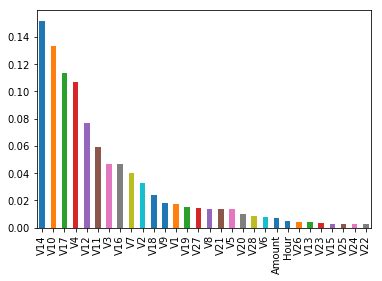

In [12]:
pd.Series(model.feature_importances_, index=X_.columns).sort_values(ascending=False).plot(kind='bar');

In [13]:
def plotPrecRecCurve(precision, recall, subset):
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    aucPrecRec = auc(recall, precision)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve %s data, AUC = %0.3f' %(subset, aucPrecRec));        

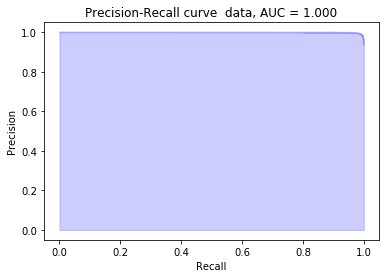

In [14]:
pred_sampled = model.predict_proba(X_sampled)[:,1]
precision, recall, thresh = precision_recall_curve(y_sampled, pred_sampled)
plotPrecRecCurve(precision, recall, "")

# Calculate AUC on train and test sets without sampling

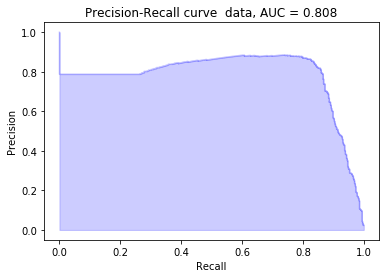

In [15]:
pred_ = model.predict_proba(X_)[:,1]
precision, recall, thresh = precision_recall_curve(y_, pred_)
plotPrecRecCurve(precision, recall, "")

# Setting the threshold

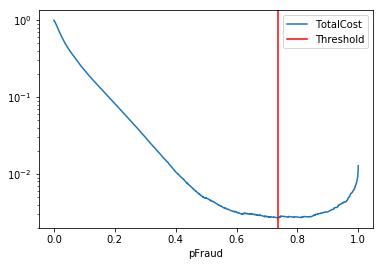

In [16]:
from dfply import *
def calculateThreshold(y_, pred_):

#     from dfply import *

    fpr, tpr, threshROC = roc_curve(y_, pred_, drop_intermediate=False)
    fpr = fpr[np.where(threshROC <= 1)]
    tpr = tpr[np.where(threshROC <= 1)]
    threshROC = threshROC[np.where(threshROC <= 1)]

    pFraud = y_.sum()/len(y_)
    pNonFraud = 1-pFraud

    # profitability calculation
    prof = pd.concat([pd.DataFrame({'pNonFraud': 1-threshROC, 'pFraud': threshROC}),
                      pd.DataFrame({'fpr': fpr, 'tpr': tpr})], axis=1) >> \
        arrange(X.pFraud) >> \
        mutate( TotalCost = float(pFraud) * ((1-X.tpr) * 10) + float(pNonFraud) * (X.fpr * 1) )

    # select threshold where cost is minimal
    threshold = prof >> \
        mask(X.TotalCost == np.min(X.TotalCost)) >> \
        select('pFraud') >>\
        rename(threshold=X.pFraud)

    threshold = threshold.iloc[0,0]
        
    prof.plot(x='pFraud', y='TotalCost', kind='line', logy=True);
    plt.axvline(x=threshold, color='r', linestyle='-')
    plt.legend(['TotalCost', 'Threshold'])
    plt.show();

    return threshold
        
threshold = calculateThreshold(y_, pred_)

# Can we explain the unusual precision recall curve with tsne?

### Plot t-SNE results

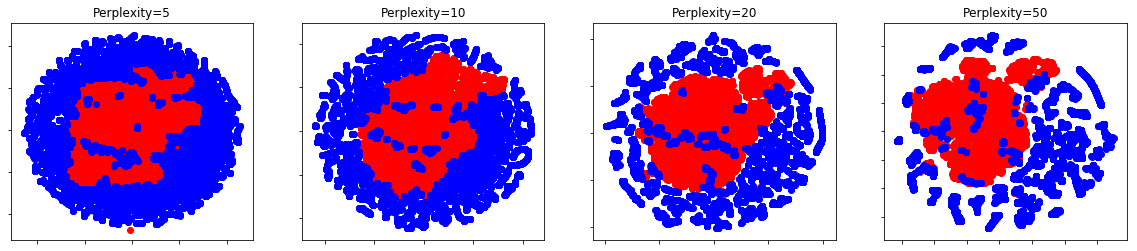

In [17]:
from sklearn.manifold import TSNE
from time import time
from matplotlib.ticker import NullFormatter

(fig, subplots) = plt.subplots(1, 4, figsize=(20, 4))
perplexities = [5, 10, 20, 50]

red = y_sampled == 0
blue = y_sampled == 1

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    tsne = TSNE(n_components=2, init='random', 
                random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X_sampled)

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[blue, 0], Y[blue, 1], c="b")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

### Plot t-SNE with different threshold levels

In [18]:
coords = pd.DataFrame(np.concatenate([Y, 
                                      np.vstack([pred_sampled, 
                                                 y_sampled]).T], axis=1), 
                      columns=['x', 'y', 'prediction', 'true'])

coords = coords.loc[np.random.choice(coords.index, 200)]

quantiles = [x for x in enumerate(coords.prediction.quantile(np.linspace(1, 0, 16)))]

for i, q in quantiles:
    coords['Thr_%d' %i] = np.where(coords.prediction >= q, '+', '.')

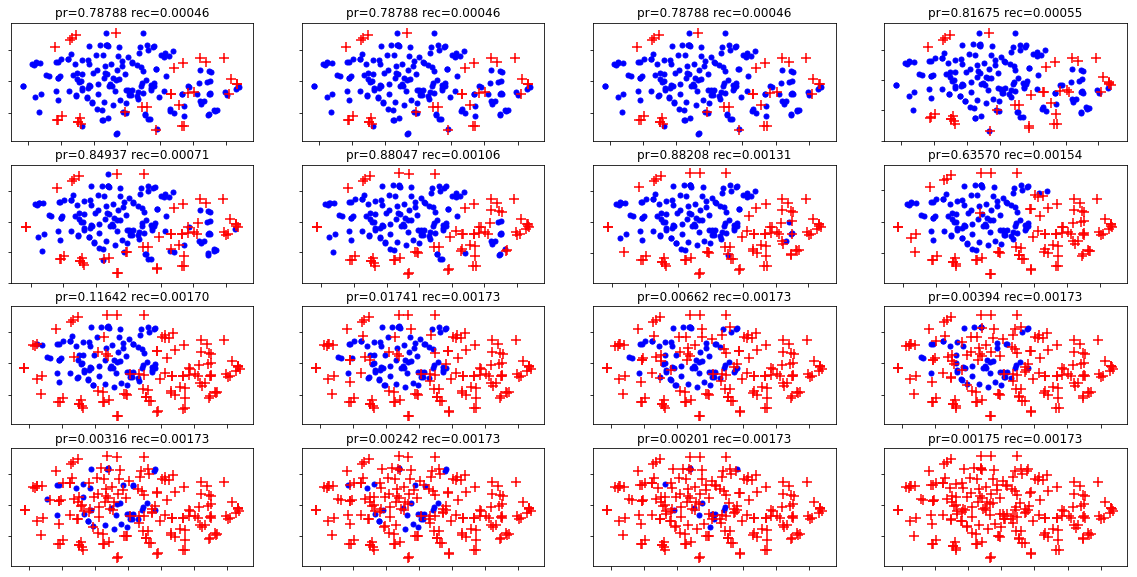

In [19]:
(fig, subplots) = plt.subplots(4, 4, figsize=(20, 10))

size = 100

confusion_matrix=[(0, '.', 'b'),
                  (0, '+', 'r'),
                  (1, '.', 'b'),
                  (1, '+', 'r')]

for i, q in quantiles:
    ax = subplots[i//4][i%4]

#     precision = y_sampled[pred_sampled >= q].sum() / (pred_sampled >= q).sum()
#     recall = y_sampled[pred_sampled >= q].sum() / len(y_sampled)
    
    precision = y_[pred_ >= q].sum() / (pred_ >= q).sum()
    recall = y_[pred_ >= q].sum() / len(y_)
    
    ax.set_title("pr=%.5f rec=%.5f" %(precision, recall))
    
    for tr, pr, c in confusion_matrix:
        ax.scatter(coords.loc[(coords.true==tr) & (coords.loc[:, 'Thr_%d'%i] == pr), 'x'], 
                   coords.loc[(coords.true==tr) & (coords.loc[:, 'Thr_%d'%i] == pr), 'y'], 
                   c=c,
                   marker=pr,
                   s=size)

    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight');